# Introduction to Multiple Output Gaussian Processes

Author: Mike Smith. 

Based on notebooks by Neil Lawrence and Ricardo Andrade, and the presentation and paper by Mauricio Alvarez.

In the basic regression example we only had one output we were trying to predict. If we have two outputs, we may be able to use one to support the predictions of another. Just to illustrate, for a dataset of dialysis patients I recently worked with, the almost daily blood pressure could be combined with the monthly blood-Potassium samples to allow predictions of both to be improved.

This notebook follows the order of concepts introduced in the lecture by Mauricio Alvarez;

<iframe width="560" height="315" src="https://www.youtube.com/embed/ttgUJtVJthA" frameborder="0" allowfullscreen></iframe>

### Intrinsic Coregionalisation Model (ICM)

First we consider a rank-one Intrinsic Coregionalisation Model (ICM), often called a multitask Gaussian process. In this most simple case we believe our two functions are scaled samples from the same GP:

$f_1(x) = a_1^1 u^1(x)$

$f_2(x) = a_2^1 u^1(x)$

(the superscripts refer to an index, which we'll use later)

In normal GP regression we are interested in the covariance between data points in the same dataset. For my example above, between the values of potassium in different weeks. In coregionalisation we are interested in not only the covariance between values of the same variable, but the covariance between values of different variables, for example between the potassium on day 1 and blood pressure on day 6.

Our (zero mean) covariance between the two domains is computed using the standard expression $\langle f_1(x) f_2(x') \rangle$, which when we substitute in the expressions for $f_1$ and $f_2$ leads to: $a_1^1 a_2^1 \langle u_1(x) u_1(x') \rangle$, where $\langle u_1(x) u_1(x') \rangle$ is $k(x,x')$. We can therefore express the covariance between the two domains as:

$$ 
\begin{bmatrix}
    (a_1^1)^2 & a_1^1 a_2^1 \\
    a_2^1 a_1^1 & (a_2^1)^2 \\
\end{bmatrix} k(x,x') = W W^\top k(x,x') = B \; k(x,x')
$$

Where $W$ is a matrix comtaining the $a$ vectors.

When $k$ is replaced with a covariance **matrix**, $K$, the above product can be expressed using a <a href="https://en.wikipedia.org/wiki/Kronecker_product">kronecker-product</a>:

$$
B \otimes K
$$

In GPy, the coregionalization matrix $B$ is the sum of the $W W^\top$ with an additional diagonal matrix $\kappa$, which we'll look at later.

Importantly though, by selecting rank=1 in GPy, we are only really specifying the rank of $W$. $B$ can always be full rank as $\kappa$ provides values along the diagonal.

In [41]:
# load modules, and generate example data
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import numpy as np
np.random.seed(0)
N0 = 30
N1 = 30
N2 = 40
N3 = 30
X0 = np.random.rand(N0)[:,None]
X1 = np.random.rand(N1)[:,None]
X2 = np.random.rand(N2)[:,None]
X3 = np.random.rand(N3)[:,None]
Y0 = 1*X0+np.random.randn(N0,1)*0.15
Y1 = 0.5*X1+np.random.randn(N1,1)*0.1
Y2 = -0.5+0.5*np.sin(X2*10)+np.random.randn(N2,1)*0.1
Y3 = np.sin(X3*10)+np.random.randn(N3,1)*0.05
keep = ((X2<0.4) | (X2>0.7))[:,0]
X2 = X2[keep,:]
Y2 = Y2[keep,:]
keep = ((X0<0.3) | (X0>0.7))[:,0]
X0 = X0[keep,:]
Y0 = Y0[keep,:]
X0widx = np.c_[X0,np.ones(X0.shape[0])*0]
X1widx = np.c_[X1,np.ones(X1.shape[0])*1]
X2widx = np.c_[X2,np.ones(X2.shape[0])*2]
X3widx = np.c_[X3,np.ones(X3.shape[0])*3]
X = np.r_[X0widx,X1widx,X2widx,X3widx]
Y = np.r_[Y0,Y1,Y2,Y3]

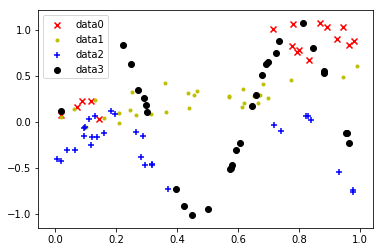

In [42]:
cols = ['r','y','b','k']
marks = ['x','.','+','o']
for reg in range(4):
    plt.scatter(X[X[:,1]==reg,0],Y[X[:,1]==reg,0],c=cols[reg],marker=marks[reg],label='data%d'%reg)
plt.legend()

Here we have four sets of data, we want to model them together because we believe there is some correlation between their values. (in particular we might expect the last two data to be related as they are both computed from the same scale sine, and the first two as they're both linear.

To use GPy to model this data, we need two matrices, the inputs $X$ and the outputs $y$. $y$ is simply the value of each input specified in X. The input matrix is a little more involved. It must consist of the series of input values, as usual (in this case there is just one dimension in the input domain), and a final column that tells GPy which dataset or 'region' the data came from. In this case there are four datasets, so this column will have values $0$, $1$, $2$ and $3$.

In [43]:
X[0::5,:] #plotting every fifth row of X, for demonstration

array([[ 0.715,  0.   ],
       [ 0.071,  0.   ],
       [ 0.87 ,  0.   ],
       [ 0.143,  0.   ],
       [ 0.568,  1.   ],
       [ 0.944,  1.   ],
       [ 0.06 ,  1.   ],
       [ 0.315,  1.   ],
       [ 0.102,  1.   ],
       [ 0.466,  1.   ],
       [ 0.197,  2.   ],
       [ 0.096,  2.   ],
       [ 0.283,  2.   ],
       [ 0.064,  2.   ],
       [ 0.132,  2.   ],
       [ 0.829,  2.   ],
       [ 0.962,  3.   ],
       [ 0.223,  3.   ],
       [ 0.297,  3.   ],
       [ 0.882,  3.   ],
       [ 0.644,  3.   ],
       [ 0.66 ,  3.   ]])

In [44]:
#this ** operation is the kronecker product between the normal (RBF) kernel
#on the inputs (which ignores the region index column and produces #the
#covariance $K$ above), and the coregionalisation matrix B.
#
#The covariance matrix is specified to have one input_dim (the last column)
#I don't think this is ever greater than one.
#
#by having rank=1 it has the structure as described above.

kern = GPy.kern.RBF(1,lengthscale=0.1)**GPy.kern.Coregionalize(input_dim=1,output_dim=4, rank=1)
m = GPy.models.GPRegression(X,Y,kern)

#to see how restrictive a true rank-1 matrix B would be, uncomment this line
#and run the optimisation again. This will enforce a covariance matrix that
#is the product of WW^T where W is a 3x1 matrix.
#m.mul.coregion.kappa.fix(0)
m.optimize()

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


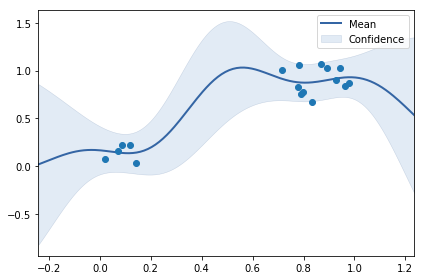

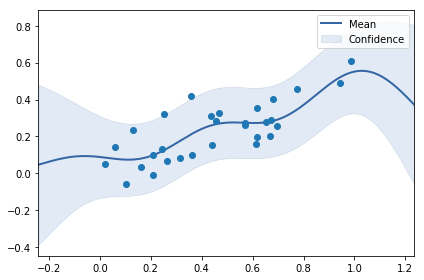

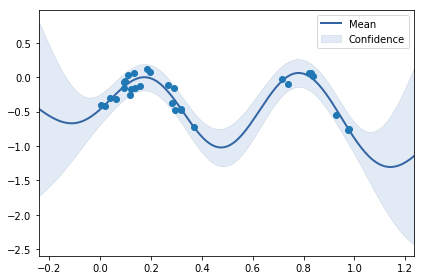

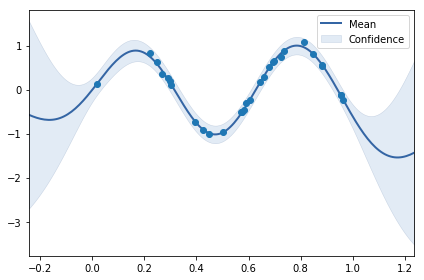

In [45]:
#here we plot the predictions for the three outputs
#by fixing the 'region' axis (column of X) to be either
#0 1 2 or 3. GPy's plot function plots all the data - even
#from other regions, so we turn off plotting and plot
#just the data in that region
for region in range(4):
    m.plot(fixed_inputs=[(1,region)],plot_data=False)
    plt.plot(X[X[:,1]==region,0],Y[X[:,1]==region,0],'o')

In [46]:
m

GP_regression.,value,constraints,priors
mul.rbf.variance,0.0817011538509,+ve,
mul.rbf.lengthscale,0.246519630366,+ve,
mul.coregion.W,"(4, 1)",,
mul.coregion.kappa,"(4,)",+ve,
Gaussian_noise.variance,0.00866184421637,+ve,


The coregionalization is made up of two hyperparameters, $W$ and kappa, $\kappa$.

The earlier $a$ vectors are here specified in the $W$ matrix, but with an additional diagonal matrix described by $\kappa$.

$$ \mathbf{B} = \mathbf{W}\mathbf{W}^\top + \text{diag}(\kappa)$$

In [47]:
B = m.mul.coregion.B
#we could also work it out from W and kappa:
#B = np.dot(m.mul.coregion.W,m.mul.coregion.W.T)+np.diag(m.mul.coregion.kappa)

#here I print out B,
print(B)
#then we look at the correlations (rather than covariances)
(B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))

[[  4.959   0.982  -6.191  -9.525]
 [  0.982   0.967  -2.564  -3.944]
 [ -6.191  -2.564  16.163  24.869]
 [ -9.525  -3.944  24.869  42.658]]


array([[ 1.   ,  0.448, -0.691, -0.655],
       [ 0.448,  1.   , -0.648, -0.614],
       [-0.691, -0.648,  1.   ,  0.947],
       [-0.655, -0.614,  0.947,  1.   ]])

The non-zero values on the off-diagonals of the coregionalisation matrix indicate that GPy has found a ML solution in which the different output regions have some covariance structure. If it were zeros on the off-diagonals then it would mean the outputs would be modelled independently.

We can see that the correlation between the two similar (sine) outputs (the last two) is very close to 1: I.e. the covariance between pairs of locations between the two different outputs is almost equal (with variance scaling) to the correlation between points in the same output.

The two linear outputs however don't appear to be using the coregionalisation. In fact they're coregionalising more with the sinusoids than with each other. This is probably a symptom of the choice of rank (which we'll look at in a bit).

We can see the effect of the coregionalisation if we turn it off. We can do that by fixing the Ws to zero, which will lead to a diagonal coregionalisation matrix.

[[ 0.398  0.     0.     0.   ]
 [ 0.     0.069  0.     0.   ]
 [ 0.     0.     0.692  0.   ]
 [ 0.     0.     0.     1.469]]


 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


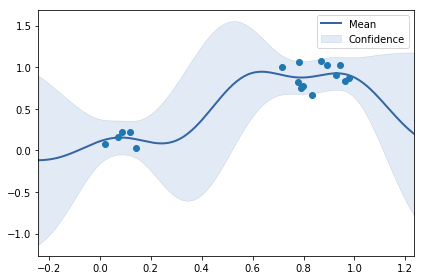

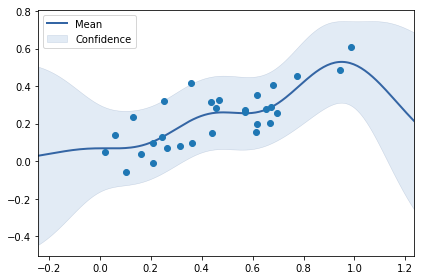

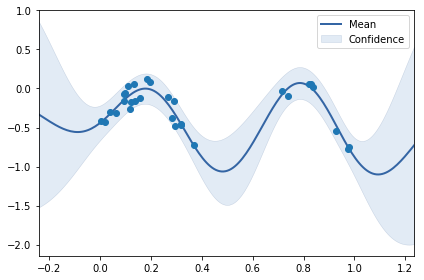

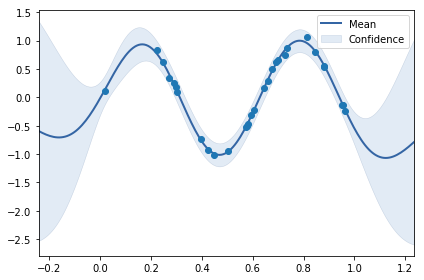

In [48]:
kern = GPy.kern.RBF(1,lengthscale=0.1)**GPy.kern.Coregionalize(input_dim=1,output_dim=4, rank=1)
m = GPy.models.GPRegression(X,Y,kern)
m.mul.coregion.W[:].fix(0)
m.optimize()
for region in range(4):
    m.plot(fixed_inputs=[(1,region)],plot_data=False)
    plt.plot(X[X[:,1]==region,0],Y[X[:,1]==region,0],'o')
B = m.mul.coregion.B
print(B)#(B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))    

Notice the estimates for the 3rd output become less certain and slightly less accurate.

### Rank

The problem with this model is that it is quite restrictive, we're assuming that all the functions are simply scaled instances of the *same* latent function. Note that we also have a diagonal matrix added, thus our coregionalisation matrix B is already full-rank (a rank one matrix, i.e. $WW^\top$, would have a correlation of one).

We can extend our model; imagine instead that our outputs are computed by the weighted sum of **two** latent functions, described (at the moment) with the same kernel. This leads to our $WW^\top$ matrix being of rank 2:

$f_1(x) = a_1^1 u^1(x) + a_1^2 u^2(x)$
$f_2(x) = a_2^1 u^1(x) + a_2^2 u^2(x)$

($u^1$ and $u^2$ are conditionally independent, so the cross-covariance is:

$a_1^1 a_2^1 \langle u_1(x) u_1(x') \rangle + a_1^2 a_2^2 \langle u_2(x) u_2(x') \rangle$

the covariances of $u_1$ and $u_2$ are the same, as they're from the same kernel, thus the covariance is just:

$(a_1^1 a_2^1 + a_1^2 a_2^2) k(x,x')$

which means the $WW^\top$ matrix is rank 2:

$$
{\mathbf{a}^1}{\mathbf{a}^1}^\top+{\mathbf{a}^2}{\mathbf{a}^2}^\top
=
\begin{bmatrix}
    (a_1^1)^2 + (a_1^2)^2 & a_1^1 a_2^1 + a_1^2 a_2^2 \\
    a_2^1 a_1^1 + a_2^2 a_1^2 & (a_2^1)^2 + (a_2^2)^2 \\
\end{bmatrix} k(x,x') = B \; k(x,x')
$$

The practical upshot is that far more variation can be expressed between the outputs, and therefore more of a prediction is likely to be based on the values of the other inputs. This can cause overfitting too. It also means there's now more parameters to fit during hyperparameter optimisation.

In this simple case there is little difference.

[[ 1.     0.793 -0.144  0.093]
 [ 0.793  1.    -0.717 -0.522]
 [-0.144 -0.717  1.     0.954]
 [ 0.093 -0.522  0.954  1.   ]]


 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


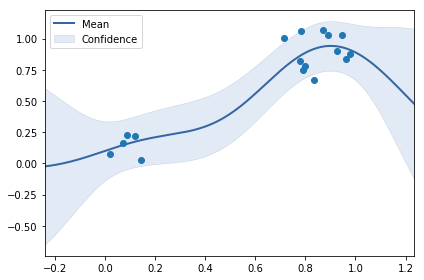

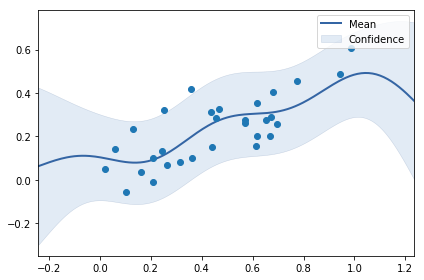

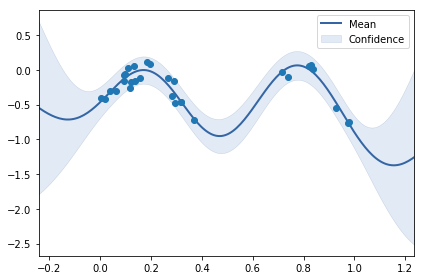

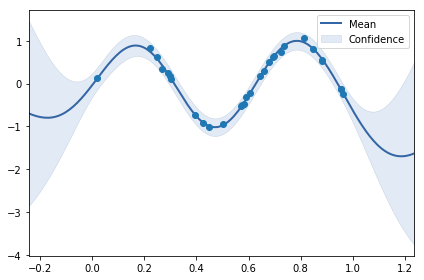

In [49]:
kern = GPy.kern.RBF(1,lengthscale=0.1)**GPy.kern.Coregionalize(input_dim=1,output_dim=4, rank=2)
m = GPy.models.GPRegression(X,Y,kern)
m.optimize()
for region in range(4):
    m.plot(fixed_inputs=[(1,region)],plot_data=False)
    plt.plot(X[X[:,1]==region,0],Y[X[:,1]==region,0],'o')
B = m.mul.coregion.B
print((B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B)))

All the predictions are now much more reasonable. Although the first output seems to coregionalise with the sinusoidal outputs still.

#### Handy tips

There are potentially a large number of hyperparameters to be fitted. If you're having trouble with coregionalisation. Consider:

1) fitting fewer outputs first, then use the values of W and kappa as initial values in a new model incorporating all the outputs.
2) You might feel some outputs shouldn't be coregionalised in some dimensions - set the appropriate row of $W$ to zero to stop them.
3) The coregionalisation method currently uses the next-column in X it's being kronecker producted with. For example if you have 2d X data, with another column for the region `rbf(1)**Coregionalise(1)` will break as it will use the 2nd dimension of the 2d X data as the coregionalisation regions.

## Linear Model of Coregionalisation

By adding together two coregionalised kernels we achieve the linear model of coregionalisation (or we would if the rank was greater than one). However I find that the optimizer struggles or we end up with a solution that's not what we would expect. In this case I've set the $W$ for the two components of the LMC to have zeros between the two types of input. Ideally GPy would learn this structure itself, but maybe there isn't enough data or structure in the data for the effect to be detected - especially given the number of hyperparameters to estimate (in this case it's got 20 or 16 with the constraints). Without these values fixed, it does produce a reasonable fit, but we can use our additional knowledge. Try commenting out the two lines that fix those particular off-diagonals and see what the result looks like.

Optimization restart 1/3, f = -67.48407149787784
Optimization restart 2/3, f = -67.48406295383988
Optimization restart 3/3, f = -67.48402510997738
RBF kernel's coregionalisation
[[ 1.     0.     0.     0.   ]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.     0.933]
 [ 0.     0.     0.933  1.   ]]
Linear kernel's coregionalisation
[[ 1.  1.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


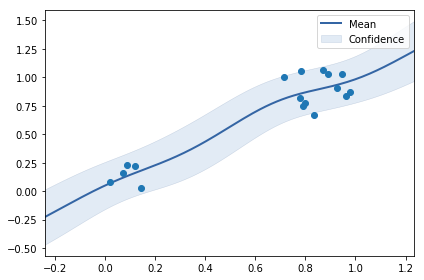

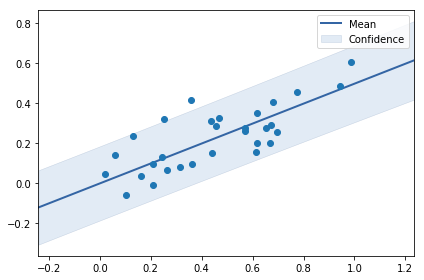

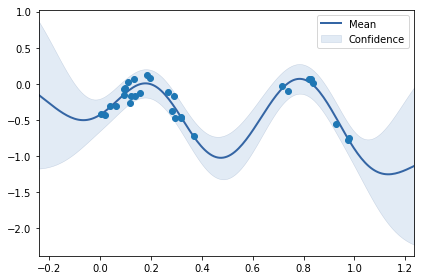

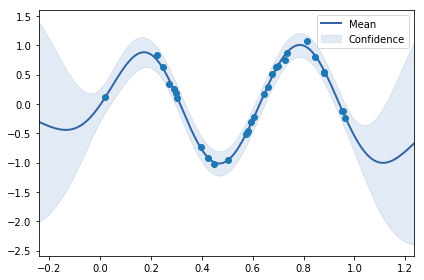

In [66]:
kern = GPy.kern.RBF(1,lengthscale=0.1)**GPy.kern.Coregionalize(input_dim=1,output_dim=4, rank=1)
kern+= GPy.kern.Linear(1)**GPy.kern.Coregionalize(input_dim=1,output_dim=4, rank=1)
m = GPy.models.GPRegression(X,Y,kern)
#artificially enforced structure of B.
m.sum.mul_1.coregion.W[2:,:].fix(0)
m.sum.mul.coregion.W[0:2,:].fix(0)

m.optimize_restarts(3)
for region in range(4):
    m.plot(fixed_inputs=[(1,region)],plot_data=False)
    plt.plot(X[X[:,1]==region,0],Y[X[:,1]==region,0],'o')
np.set_printoptions(suppress=True,precision=3)
print("RBF kernel's coregionalisation")
B = m.sum.mul.coregion.B
#print(B)
print((B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B)))
print("Linear kernel's coregionalisation")
B = m.sum.mul_1.coregion.B
#print(B)
print((B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B)))


Below is another introduction to coregionalisation using GPy, by Neil. Hopefully reading another intro, this time with real data, will help the reader understand the topic a little better.

## Another Introduction to Multiple Outputs Gaussian Processes
Author: Neil Lawrence.

Originally for the Gaussian Process Summer School, Melbourne, Australia, 25th-27th February 2015.

In [68]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import GPy
import pods
from IPython.display import display

### Running Example

The first think we will look at is a multiple output model. Our aim is to jointly model all *sprinting* events from olympics since 1896. Data is provided by Rogers & Girolami's "First Course in Machine Learning". Firstly, let's load in the data.

In [70]:
data = pods.datasets.olympic_sprints()
X = data['X']
y = data['Y']
print(data['info'], data['details'])

Olympics sprint event winning for men and women to 2008. Data is from Rogers and Girolami's First Course in Machine Learning. Data from the textbook 'A First Course in Machine Learning'. Available from http://www.dcs.gla.ac.uk/~srogers/firstcourseml/.


When using data sets it's good practice to cite the originators of the data, you can get information about the source of the data from `data['citation']`

In [71]:
print(data['citation'])

A First Course in Machine Learning. Simon Rogers and Mark Girolami: Chapman & Hall/CRC, ISBN-13: 978-1439824146


The data consists of all the male and female sprinting data for 100m, 200m and 400m since 1896 (six outputs in total). The ouput information can be found from: `data['output_info']`

In [72]:
print(data['output_info'])

{0: '100m Men', 1: '100m Women', 2: '200m Men', 3: '200m Women', 4: '400m Men', 5: '400m Women'}


In GPy we deal with multiple output data in a particular way. We specify the output we are interested in for modelling as an additional *input*. So whilst for this data, normally, the only input would be the year of the event. We additionally have an input giving the index of the output we are modelling. This can be seen from examining `data['X']`.

In [73]:
print('First column of X contains the olympic years.')
print(np.unique(data['X'][:, 0]))
print('Second column of X contains the event index.')
print(np.unique(data['X'][:, 1]))

First column of X contains the olympic years.
[ 1896.  1900.  1904.  1906.  1908.  1912.  1920.  1924.  1928.  1932.
  1936.  1948.  1952.  1956.  1960.  1964.  1968.  1972.  1976.  1980.
  1984.  1988.  1992.  1996.  2000.  2004.  2008.]
Second column of X contains the event index.
[ 0.  1.  2.  3.  4.  5.]


Now let's plot the data

Text(0,0.5,'time/s')

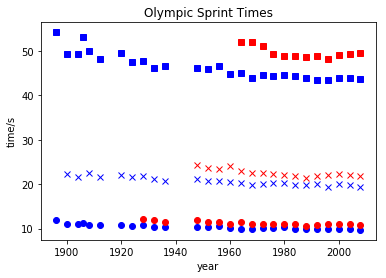

In [74]:
markers = ['bo', 'ro', 'bx', 'rx', 'bs', 'rs']
for i in range(6):
    # extract the event 
    x_event = X[np.nonzero(X[:, 1]==i), 0]
    y_event = y[np.nonzero(X[:, 1]==i), 0]
    plt.plot(x_event, y_event, markers[i])
plt.title('Olympic Sprint Times')
plt.xlabel('year')
plt.ylabel('time/s')

In the plot above red is women's events, blue is men's. Squares are 400 m, crosses 200m and circles 100m. Not all events were run in all years, for example the women's 400 m only started in 1964.

We will look at modelling the data using coregionalization approaches described in this morning's lecture. We introduced these approaches through the Kronecker product. To indicate we want to construct a covariance function of this type in GPy we've overloaded the `**` operator. Stricly speaking this operator means to the power of (like `^` in MATLAB). But for covariance functions we've used it to indicate a tensor product. The linear models of coregionalization we introduced in the lecture were all based on combining a matrix with a standard covariance function. We can think of the matrix as a particular type of covariance function, whose elements are referenced using the event indices. I.e. $k(0, 0)$ references the first row and column of the coregionalization matrix. $k(1, 0)$ references the second row and first column of the coregionalization matrix. Under this set up, we want to build a covariance where the first column from the features (the years) is passed to a covariance function, and the second column from the features (the event number) is passed to the coregionalisation matrix. Let's start by trying a intrinsic coregionalisation model (sometimes known as multitask Gaussian processes). Let's start by checking the help for the `coregionalize` covariance.

In [75]:
GPy.kern.Coregionalize?

The coregionalize matrix, $\mathbf{B}$, is itself is constructed from two other matrices, $\mathbf{B} = \mathbf{W}\mathbf{W}^\top + \text{diag}(\boldsymbol{\kappa})$. This allows us to specify a low rank form for the coregionalization matrix. However, for our first example we want to specify that the matrix $\mathbf{B}$ is not constrained to have a low rank form. 

In [76]:
kern = GPy.kern.RBF(1, lengthscale=80)**GPy.kern.Coregionalize(1,output_dim=6, rank=5)
display(kern)

mul.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,80.0,+ve,
coregion.W,"(6, 5)",,
coregion.kappa,"(6,)",+ve,


Note here that the rank we specify is that of the $\mathbf{W}\mathbf{W}^\top$ part. When this part is combined with the diagonal matrix from $\mathbf{\kappa}$ the matrix $\mathbf{B}$ is totally general. This covariance function can now be used in a standard Gaussian process regression model. Let's build the model and optimize it.

In [77]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

We can plot the results using the ability to 'fix inputs' in the `model.plot()` function. We can specify that column 1 should be fixed to event number 2 by passing `fixed_inputs = [(1, 2)]` to the model. To plot the results for all events on the same figure we also specify `fignum=1` in the loop as below. 

Text(0,0.5,'time/s')

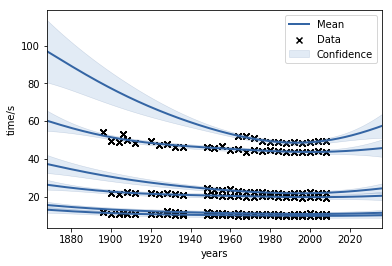

In [78]:
fig, ax = plt.subplots()
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)],ax=ax,legend=i==0)
plt.xlabel('years')
plt.ylabel('time/s')

There is a lot we can do with this model. First of all, each of the races is a different length, so the series have a different mean. We can include another coregionalization term to deal with the mean. Below we do this and reduce the rank of the coregionalization matrix to 1.

In [79]:
kern1 = GPy.kern.RBF(1, lengthscale=80)**GPy.kern.Coregionalize(1,output_dim=6, rank=1)
kern2 = GPy.kern.Bias(1)**GPy.kern.Coregionalize(1,output_dim=6, rank=1)
kern = kern1 + kern2

In [80]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

Text(0,0.5,'time/s')

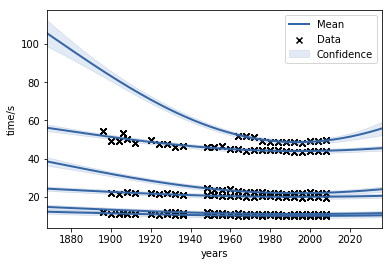

In [81]:
fig, ax = plt.subplots()
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)],ax=ax,legend=i==0)
plt.xlabel('years')
plt.ylabel('time/s')

This is a simple form of the linear model of coregionalization. Note how confident the model is about what the women's 400 m performance would have been. You might feel that the model is being over confident in this region. Perhaps we are forcing too much sharing of information between the sprints. We could return to the intrinsic coregionalization model and force the two base covariance functions to share the same coregionalization matrix.

In [82]:
m.plot?

In [86]:
kern1 = GPy.kern.RBF(1, lengthscale=80) + GPy.kern.Bias(1)
kern1.name = 'rbf_plus_bias'
kern2 = GPy.kern.Coregionalize(1,output_dim=6, rank=5)
kern = kern1**kern2
kern.name = 'product'
display(kern)

product.,value,constraints,priors
rbf_plus_bias.rbf.variance,1.0,+ve,
rbf_plus_bias.rbf.lengthscale,80.0,+ve,
rbf_plus_bias.bias.variance,1.0,+ve,
coregion.W,"(6, 5)",,
coregion.kappa,"(6,)",+ve,


In [87]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

Text(0,0.5,'time/s')

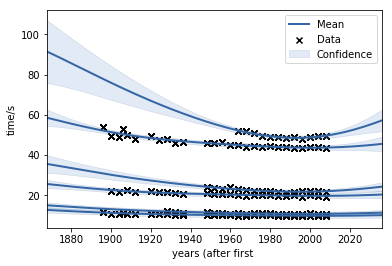

In [88]:
fig, ax = plt.subplots()
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)],ax=ax,legend=(i==0))
plt.xlabel('years (after first ')
plt.ylabel('time/s')

### Exercise 1

Can you fix the issue with over confidence in this model? Some things you might try include (a) adding additional covariance functions to handle shorter lengthscale effects. (b) Changing the rank of the coregionalization matrix. (c) Adding a coregionalized noise model using `GPy.kern.white()`.

In [89]:
# Question 1 answer here

Predictions in the multioutput case can be very effected by our covariance function *design*. This reflects the themes we saw on the first day where the importance of covariance function choice was emphasized at design time. 

Can you build a covariance matrix that coregionalizes separately over the sex of the athletes and the event identity? Does this matrix perform better?

In [90]:
# set up the inputs to index sex and event separately.
X2 = np.zeros((X.shape[0], 3))
X2[:, 0] = X[:, 0]
X2[:, 1] = np.remainder(X[:, 1],2) == 1 # Gender
X2[:, 2] = np.floor(X[:, 1]/2)          # Event

In [91]:
X2mean = X2[:,0].mean()
# Zero mean X for the linear trend to be feasible
X2m = X2.copy()
X2m[:,0] -= X2mean

In [92]:
kern = ((GPy.kern.RBF(1, variance=1, lengthscale=70)+
         GPy.kern.Linear(1, 1, active_dims=[0])+
         GPy.kern.White(1)+
         GPy.kern.Bias(1, 1))
        *GPy.kern.Coregionalize(1, output_dim=2, rank=1, active_dims=1, name='gender')
        *GPy.kern.Coregionalize(1, output_dim=3, rank=1, active_dims=2, name='event')
       )

In [93]:
#display(kern)
#print "First coregion:", [(k.name, k.active_dims) for k in kern.parts[0].parts]
#print "Second         ", [(k.name, k.active_dims) for k in kern.parts[0].parts[1].parts]

model = GPy.models.GPRegression(X2m, y, kern, normalizer=True) 
model.optimize(messages=1,max_iters=5e5)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i        f              |g|        
    00s02  000002   1.406275e+02   1.341317e+03 
    00s14  000013  -1.726552e+02   6.153390e+03 
    00s19  000018  -2.046801e+02   6.452018e+01 
    01s19  000160  -2.422794e+02   1.836512e+01 
    02s20  000332  -2.433049e+02   7.406856e-01 
    03s05  000475  -2.434629e+02   1.763720e-03 
Runtime:     03s05
Optimization status: Converged



In [94]:
print(X2mean)

1962.41269841


Text(0,0.5,'Time [s]')

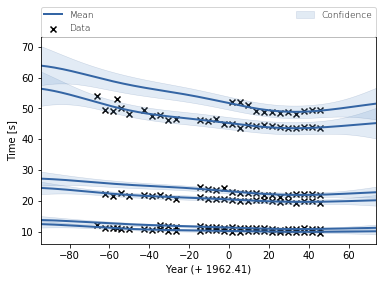

In [95]:
fig, ax = plt.subplots()
for i in range(2):
    for j in range(3):
        model.plot(fignum=1,fixed_inputs=[(1, i), (2, j)], 
                   ax=ax, legend=(i==0)*(j==0)*2, 
                   plot_data=(i==0)*(j==0))
ax.set_xlabel('Year (+ {})'.format(X2mean.round(2)))
ax.set_ylabel('Time [s]')